In [1]:
import numpy as np #matrix math 
import tensorflow as tf #machine learningt
import helpers #for formatting data into batches and generating random sequence data
from tensorflow.python.ops.rnn_cell import LSTMCell, LSTMStateTuple
from tensorflow.python.layers.core import Dense
from datasets.twitter import data
import data_utils
from tensorlayer.layers import *
import tensorlayer as tl

In [2]:


# load data from pickle and npy files
metadata, idx_q, idx_a = data.load_data(PATH='datasets/cornell_corpus/')
(trainX, trainY), (testX, testY), (validX, validY) = data_utils.split_dataset(idx_q, idx_a)

# pre-process training data part I
trainX = trainX.tolist()
trainY = trainY.tolist()
trainX = tl.prepro.remove_pad_sequences(trainX)
trainY = tl.prepro.remove_pad_sequences(trainY)

# parameters 
xseq_len = len(trainX)
yseq_len = len(trainY)
assert xseq_len == yseq_len
BATCH_SIZE = 32
xvocab_size = len(metadata['idx2w'])  
yvocab_size = xvocab_size
emb_dim = 1024

encoder_max_time = 20
decoder_max_time = encoder_max_time


In [3]:
xvocab_size

8002

In [4]:
# updata parameters with preprocessing
w2idx = metadata['w2idx']
idx2w = metadata['idx2w']
unk_id = w2idx['unk']
pad_id = w2idx['_']
start_id = xvocab_size
end_id = xvocab_size+1
w2idx.update({'start_id': start_id})
w2idx.update({'end_id': end_id})
idx2w = idx2w + ['start_id', 'end_id']
xvocab_size = yvocab_size = xvocab_size + 2

""" A data for Seq2Seq should look like this:
input_seqs : ['how', 'are', 'you', '<PAD_ID'>]
decode_seqs : ['<START_ID>', 'I', 'am', 'fine', '<PAD_ID'>]
target_seqs : ['I', 'am', 'fine', '<END_ID>', '<PAD_ID'>]
target_mask : [1, 1, 1, 1, 0]
"""

" A data for Seq2Seq should look like this:\ninput_seqs : ['how', 'are', 'you', '<PAD_ID'>]\ndecode_seqs : ['<START_ID>', 'I', 'am', 'fine', '<PAD_ID'>]\ntarget_seqs : ['I', 'am', 'fine', '<END_ID>', '<PAD_ID'>]\ntarget_mask : [1, 1, 1, 1, 0]\n"

In [53]:
iterator = tl.iterate.minibatches(inputs = trainX, targets = trainY, batch_size = BATCH_SIZE, shuffle = False)

In [52]:
fd = chatbot_train_next_batch(start_id)
fd[go_tokens].shape

(32,)

In [68]:
int(5/2)

2

In [39]:
def chatbot_train_next_batch(go_id):
    X, Y = iterator.__next__()
    #[batch_size, max_seq_len]
    _encoder_seqs = tl.prepro.pad_sequences(X)
    _target_seqs = tl.prepro.sequences_add_end_id(Y, end_id = end_id)
    ##[batch_size, max_seq_len]
    _target_seqs = tl.prepro.pad_sequences(_target_seqs)
    _decode_seqs = tl.prepro.sequences_add_start_id(Y, start_id = start_id, remove_last = False)
    #[batch_size, max_seq_len]
    _decode_seqs = tl.prepro.pad_sequences(_decode_seqs)
    #[batch_size, max_seq_len]
    _target_masks = tl.prepro.sequences_get_mask(_target_seqs)
    return {
        encoder_inputs: np.array(_encoder_seqs).T,
        decoder_targets: np.array(_target_seqs).T,
        decoder_masks: _target_masks.T,
        go_tokens: np.zeros(len(_encoder_seqs)) + go_id
    }

In [54]:
tf.reset_default_graph()

In [67]:
xvocab_size

8004

In [55]:


vocab_size = xvocab_size
input_embedding_size = emb_dim #character length

encoder_hidden_units = emb_dim #num neurons
decoder_hidden_units = encoder_hidden_units * 2

- `encoder_inputs` int32 tensor is shaped `[encoder_max_time, batch_size]`
- `decoder_targets` int32 tensor is shaped `[decoder_max_time, batch_size]`

In [56]:
#inputs dimension [encoder_max_time, batch_size]
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
#contains the lengths for each of the sequence in the batch, we will pad so all the same
#if you don't want to pad, check out dynamic memory networks to input variable length sequences
#retrieve_seq_length need argument with shape [batch_size, max_seq_len]
encoder_inputs_length = retrieve_seq_length_op2(tf.transpose(encoder_inputs))
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')
#target_masks [max_seq_len, batch_size]
decoder_masks = tf.placeholder(shape = (None, None), dtype = tf.int32, name = 'decoder_masks')
go_tokens = tf.placeholder(shape = (None,), dtype = tf.int32, name = 'go_tokens')

### Define Embedding Matrix

In [57]:
with tf.device("/cpu:0"):
    #randomly initialized embedding matrrix that can fit input sequence
    #used to convert sequences to vectors (embeddings) for both encoder and decoder of the right size
    #reshaping is a thing, in TF you gotta make sure you tensors are the right shape (num dimensions)
    embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

    #this thing could get huge in a real world application

    encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
    decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, decoder_targets)

### Preprocess inputs and outputs
- my_encoder_inputs: Dimension(8, batch_size)
- my_encoder_inputs_length: Dimension(batch_size)
- my_decoder_targets: Dimension(11, batch_size)

In [58]:


batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)
def next_feed():
    batch = next(batches)
    encoder_inputs_, encoder_input_lengths_ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] + [PAD] * 2 for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
    }

In [247]:
orig = next_feed()

In [248]:
def get_seq_len(batch_x):
    #batch_x with shape [seq_len, batch_size]
    return [np.nonzero(batch_x[:,i])[0].size for i in range(batch_x.shape[1])]

### Define Encoder as Bidirectional LSTM Cell

In [59]:
encoder_cell = LSTMCell(encoder_hidden_units)

((encoder_fw_outputs,
  encoder_bw_outputs),
 (encoder_fw_final_state,
  encoder_bw_final_state)) = (
    tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell,
                                    cell_bw=encoder_cell,
                                    inputs=encoder_inputs_embedded,
                                    sequence_length=encoder_inputs_length,
                                    dtype=tf.float32, time_major=True)
    )

#Concatenates tensors along one dimension.
encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), 2)

#letters h and c are commonly used to denote "output value" and "cell state". 
#http://colah.github.io/posts/2015-08-Understanding-LSTMs/ 
#Those tensors represent combined internal state of the cell, and should be passed together. 

encoder_final_state_c = tf.concat(
    (encoder_fw_final_state.c, encoder_bw_final_state.c), 1)

encoder_final_state_h = tf.concat(
    (encoder_fw_final_state.h, encoder_bw_final_state.h), 1)

#TF Tuple used by LSTM Cells for state_size, zero_state, and output state.
encoder_final_state = LSTMStateTuple(
    c=encoder_final_state_c,
    h=encoder_final_state_h
)

### Define Decoder as Basic LSTM Cell

In [60]:
decoder_cell = LSTMCell(decoder_hidden_units)
encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))
#????????????
decoder_lengths = encoder_inputs_length * 0 + tf.reduce_max(retrieve_seq_length_op2(tf.transpose(decoder_masks)))
# +2 additional steps, +1 leading <EOS> token for decoder inputs
projection_layer = Dense(units = vocab_size, use_bias = True)
#Training Helper
# helper = tf.contrib.seq2seq.TrainingHelper(
#         decoder_inputs_embedded, decoder_lengths, time_major = True)
#Inferencing Helper
helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(embeddings, start_tokens = go_tokens, end_token = end_id)
decoder = tf.contrib.seq2seq.BasicDecoder(
        decoder_cell, helper, encoder_final_state, output_layer = projection_layer)
decoder_outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(decoder = decoder,output_time_major = True, maximum_iterations= 20)

### Loss and Prediction

In [61]:
logits = decoder_outputs.rnn_output
decoder_prediction = tf.argmax(logits, 2)
#cross_entropy with shape [max_seq_len, batch_size]
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(
        labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
        logits = logits)

#loss function
loss = tf.reduce_mean(cross_entropy * tf.cast(decoder_masks, tf.float32))
#train it 
train_op = tf.train.AdamOptimizer().minimize(loss)
# train_op = tf.train.MomentumOptimizer(0.01,0.9).minimize(loss)

In [62]:

sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=True,device_count={'GPU':1}))
sess.run(tf.global_variables_initializer())

/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [63]:
fd = chatbot_train_next_batch(start_id)
predict_ = sess.run(decoder_prediction, fd)

In [23]:


loss_track = []
max_batches = 5001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = chatbot_train_next_batch()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % (batches_in_epoch) == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.8437368869781494
  sample 1:
    input     > [   3   16  263   37   18    6 2483 7144   13  124   97   19   23  285
 1884   24  259  226 2066]
    predicted > [   3    3    3    3    3    9    9    4    4    1    9    1    1    5
    4    5   11    3    3    3 8003    2    2 8003 8003]
  sample 2:
    input     > [  32   31   35    6 1554 1529    0    0    0    0    0    0    0    0
    0    0    0    0    0]
    predicted > [  37    2    2    2 8003 8003 8003 8003 8003 8003 8003 8003 8003  623
  623  623  623 1289 1289 1289 1289 1289 1289 1289 1289]
  sample 3:
    input     > [ 61   3  16  88 102  31   6 483 419   0   0   0   0   0   0   0   0   0
   0]
    predicted > [  87   13 8003 8003 8003 8003 8003 8003 8003 8003  623  623  623  623
  623  623  623  623 1289 1289 1289 1289 1289 1289 1289]

batch 1000
  minibatch loss: 0.060268811881542206
  sample 1:
    input     > [120   2  52  76  12   8  75  82 124  13   9   1  22 260  85   1  44  58
  17 279   0

StopIteration: 

In [24]:
fd[encoder_inputs][:,15]

array([  4, 503,  10,  25, 265,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0])

In [64]:
q_s = [decode(sequence=fd[encoder_inputs][:,i], lookup=idx2w, separator=' ') for i in range(32)]
a_s = [decode(sequence=predict_[:,i], lookup=idx2w, separator=' ') for i in range(32)]

In [31]:
def decode(sequence, lookup, separator=''): # 0 used for padding, is ignored
    res = ''
    for i in range(len(sequence)):
        if sequence[i] != 0 and sequence[i] != 6003:
            res += lookup[sequence[i]]+' '
        else:
            return res
    return res
    

In [273]:
decode(sequence=[2,3,4,6003,2,1], lookup=idx2w, separator=' ')

'the to i '

In [65]:
for i in range(32):
    print('--------------------------------------------------------------')
    print('    Q > {}'.format(q_s[i]))
    print('    A > {}'.format(a_s[i]))
    print('--------------------------------------------------------------')

--------------------------------------------------------------
    Q > can we make this quick unk unk and andrew barrett are having an incredibly unk public break up on the unk again 
    A > global perspective sudden killing shoots jewelry massey massey neither neither cross yoda accomplished der dated li brilliant cathy cathy audience 
--------------------------------------------------------------
--------------------------------------------------------------
    Q > not the unk and unk and unk part please 
    A > craft stupidity pete dropping yep seventyfive drove child loved toast active cab nap known leak ginger officially peaceful aware digging 
--------------------------------------------------------------
--------------------------------------------------------------
    Q > youre asking me out thats so cute whats your name again 
    A > enemy obvious sunny sunny truth truth side thirtysix jammed elena ocean elsewhere frock ethics claudia mothers patient fright sticking phras

loss 0.0001 after Tensor("mul_2:0", shape=(), dtype=int32) examples (batch_size=Tensor("unstack:1", shape=(), dtype=int32))


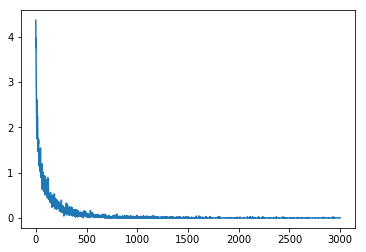

In [278]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))

In [52]:
sess.close()

In [85]:
from tensorlayer.layers import *
import tensorlayer as tl

In [87]:
w2idx = metadata['w2idx']
idx2w = metadata['idx2w']
unk_id = w2idx['unk']
pad_id = w2idx['_']
start_id = xvocab_size
end_id = xvocab_size+1
w2idx.update({'start_id': start_id})
w2idx.update({'end_id': end_id})
idx2w = idx2w + ['start_id', 'end_id']
xvocab_size = yvocab_size = xvocab_size + 2

In [92]:
trainX = trainX.tolist()

In [96]:
trainX = tl.prepro.remove_pad_sequences(trainX)

In [99]:
len(trainX)

187262

In [100]:
trainY.shape

(187262, 20)

In [102]:
print([idx2w[id] for id in trainX[10]])

['dad', 's', 'dad', 'is', 'our', 'new', 'favorite', 'person']


In [103]:
trainY = trainY.tolist()
trainY = tl.prepro.remove_pad_sequences(trainY)
target_seqs = tl.prepro.sequences_add_end_id([trainY[10]], end_id)[0]

In [104]:
target_seqs

[78, 342, 63, 68, 746, 6003]

In [105]:
print([idx2w[id] for id in target_seqs])

['u', 'gotta', 'love', 'his', 'dad', 'end_id']


In [106]:
decode_seqs = tl.prepro.sequences_add_start_id([trainY[10]], start_id = start_id, remove_last = False)[0]

In [107]:
decode_seqs

[6002, 78, 342, 63, 68, 746]

In [108]:
print([idx2w[id] for id in decode_seqs])

['start_id', 'u', 'gotta', 'love', 'his', 'dad']


In [109]:
target_mask = tl.prepro.sequences_get_mask([target_seqs])

In [116]:
target_mask[0]

array([1, 1, 1, 1, 1, 1])

In [118]:
feeder = chatbot_train_next_batch()

In [122]:
X, Y = trainX[0:16], trainY[0:16]

In [123]:
X = tl.prepro.pad_sequences(X)

In [130]:
_target_seqs = tl.prepro.sequences_add_end_id(Y, end_id = end_id)

In [134]:
_target_seqs = tl.prepro.pad_sequences(_target_seqs)

In [140]:
_target_mask = tl.prepro.sequences_get_mask(_target_seqs)

In [153]:
_target_mask.shape

(16, 20)

In [155]:
_decode_seqs = tl.prepro.sequences_add_start_id(Y, start_id = start_id, remove_last = False)
_decode_seqs = tl.prepro.pad_sequences(_decode_seqs)